In [70]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE, mean_absolute_percentage_error as MAPE, mean_squared_error as MSE 
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.data import load_data
from src.metric import regressionSummary,adjusted_r2_score
import pprint as pp
pd.set_option('precision',4)
pd.options.display.max_rows = 200
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prediction and Estimation
Estimation is about finding a model that explains existing data as well as possible, while predictive models are best when they can determine unknown values given the independent factors.

## Evaluating Predictive Performance
Evaluating performance of predictive or estimation models which use continuous targets uses a different technique than quantifying error rates.  Predictions are not simply correct or incorrect, but we can decide how close we were in our prediction or how far away.  A few techniques to determine performance of continuous target predictions include: 

* Mean Error - the average difference between the predicted and expected target
  * Valuable if the direction of the prediction is important (too high or too low) though it can be misleading since too-high and too-low can cancel each other out.
* MAE - Mean absolute error - the average difference between the predicted and expected target not accounting for sign 
(+/-)
  * takes the too high or too low issue out of play
* MPE - Mean percentage error - average percentage difference between predicted and expected target
* MAPE - Mean absolute percentage error - average percentage difference between predicted and expected target (using absolute values rather than positive or negative error)
* MSE - Mean square error - average of the square of the error of each prediction
  * penalizes significant outliers and removes units so it is a relative metric only
* RMSE - Root mean square error - square root of the average of the square of the error of each prediction (provides relative units)
  * still significantly penalizes bigger errors but also provides units of the base metric


## Multiple Linear Regression
Linear regression models are a great model to explain a linear relationship between predictors and target variables (assuming a linear relationship exists).  They are easy to explain and have a built-in metric to identify the importance of each predictor.  Also, we can use this information to include just enough of the variables to accurately describe the target possibly reducing the complexity

With linear regression we are attempting to describe a target variable in terms of a set of coefficients in a linear equation such as:
$$Y = \beta_0+\beta_1X_1+\beta_2X_2 + ... \beta_nX_n + \epsilon$$
where $\beta$ represents coefficients and $X$ are the predictive factors (independent variables) and $\epsilon$ is _noise_ or _unexplainable_ part.  Data is used to estimate the coefficients and quantify the noise.

## Medical Insurance Forecast
Insurance companies need to set the insurance premiums following the population trends despite having limited information about the insured population if they have to put themselves in a position to make profits. This makes it necessary to estimate the average medical care expenses based on trends in the population segments, such as smokers, drivers, etc

[data dictionary](../data/insurance.csv#insurance)

In [46]:
insurance_df = load_data('insurance')
# Start with checking our the first few rows
insurance_df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.9240
1,18,male,33.770,1,no,southeast,1725.5523
2,28,male,33.000,3,no,southeast,4449.4620
3,33,male,22.705,0,no,northwest,21984.4706
4,32,male,28.880,0,no,northwest,3866.8552


In [47]:
# We need to let pandas know that we have categorical data in a couple columns
insurance_df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [48]:
# Categorize the columns
for c in ['sex','smoker','region']:
    insurance_df[c]=insurance_df[c].astype('category')

<AxesSubplot:>

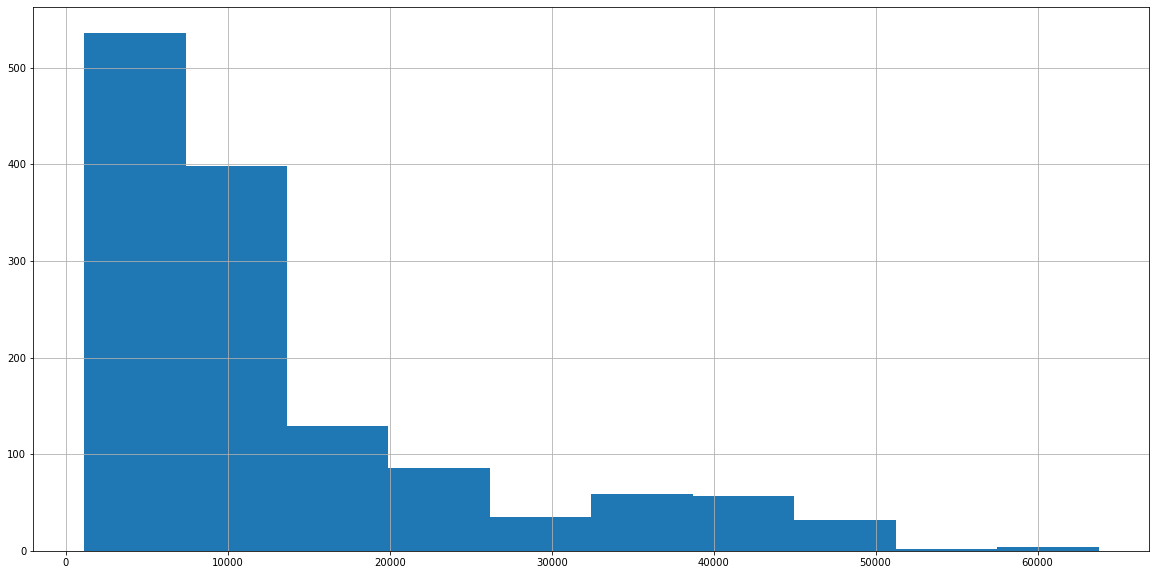

In [49]:
# What's the range of charges
insurance_df.charges.hist()

<AxesSubplot:xlabel='region', ylabel='charges'>

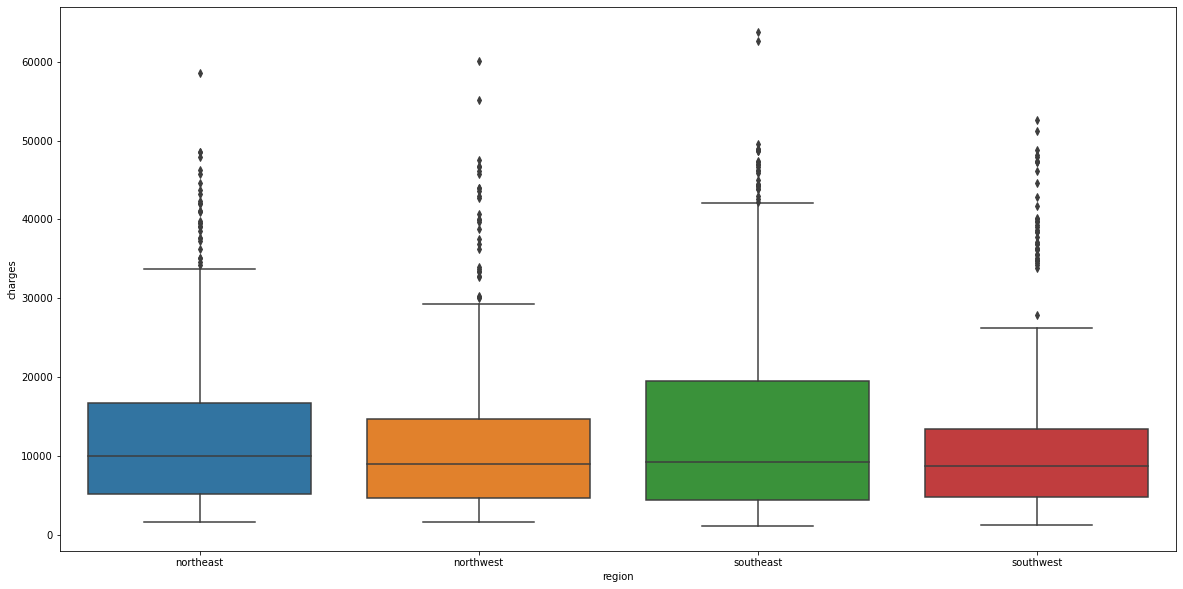

In [50]:
plt.rcParams["figure.figsize"] = (20, 10)
sns.boxplot(data=insurance_df, x='region',y='charges')

### About BMI
The CDC has the following [guidance][1] with regard to interpreting BMI:
> * If your BMI is less than 18.5, it falls within the underweight range.
> * If your BMI is 18.5 to <25, it falls within the healthy weight range.
> * If your BMI is 25.0 to <30, it falls within the overweight range.
> * If your BMI is 30.0 or higher, it falls within the obesity range.

It seems like a good idea to build categories for these values

[1]: ([https://www.cdc.gov/obesity/adult/defining.html#:~:text=Adult%20Body%20Mass%20Index%20%28BMI%29%20%20%20,%20%20Obesity%20%201%20more%20rows%20)

In [51]:
# Build the categories for BMI based on CDC guidance
insurance_df['bmi_cat'] = pd.cut(insurance_df.bmi,
    bins=[0,18.5,25,30,100],
    labels=['underweight','healthy','overweight','obese'])

<AxesSubplot:xlabel='bmi_cat', ylabel='charges'>

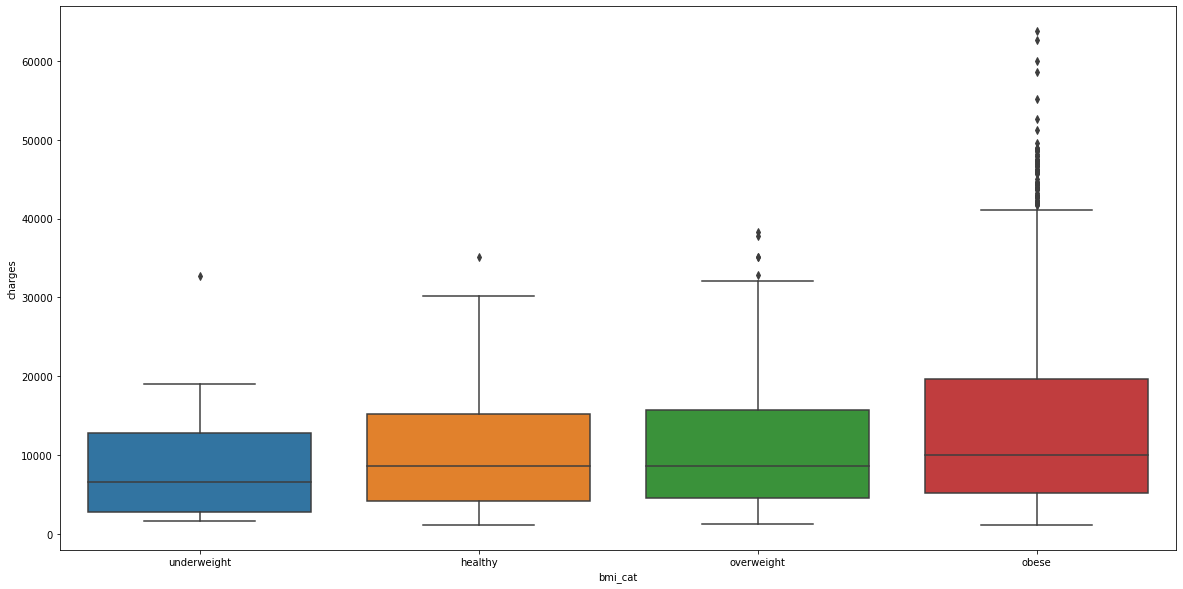

In [52]:
# Now let's take a look to see if this plays a role
sns.boxplot(data=insurance_df, x='bmi_cat',y='charges')

We are seeing exactly what we suspect that individuals that are overweight or obese are more likely to cause the insurance company more.  We could quanitify it as well

In [53]:
# What's the actual difference in average cost
insurance_df.groupby('bmi_cat')['charges'].mean()

bmi_cat
underweight     8657.6207
healthy        10435.4407
overweight     10997.8039
obese          15560.9263
Name: charges, dtype: float64

You may want to do some more digging into the data or creating some other new factors to help determine if we can find a good predictive model.  We'll use what we have here.

In [54]:
# We need to ensure that our data is 'encoded' to work with the linear model
num_columns=insurance_df.select_dtypes(include='number').columns
cat_columns=insurance_df.select_dtypes(exclude='number').columns
num_columns
cat_columns

Index(['age', 'bmi', 'children', 'charges'], dtype='object')

Index(['sex', 'smoker', 'region', 'bmi_cat'], dtype='object')

In [55]:
new_ins_df = pd.get_dummies(insurance_df,columns=cat_columns)
new_ins_df

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,bmi_cat_underweight,bmi_cat_healthy,bmi_cat_overweight,bmi_cat_obese
0,19,27.900,0,16884.9240,1,0,0,1,0,0,0,1,0,0,1,0
1,18,33.770,1,1725.5523,0,1,1,0,0,0,1,0,0,0,0,1
2,28,33.000,3,4449.4620,0,1,1,0,0,0,1,0,0,0,0,1
3,33,22.705,0,21984.4706,0,1,1,0,0,1,0,0,0,1,0,0
4,32,28.880,0,3866.8552,0,1,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.5483,0,1,1,0,0,1,0,0,0,0,0,1
1334,18,31.920,0,2205.9808,1,0,1,0,1,0,0,0,0,0,0,1
1335,18,36.850,0,1629.8335,1,0,1,0,0,0,1,0,0,0,0,1
1336,21,25.800,0,2007.9450,1,0,1,0,0,0,0,1,0,0,1,0


In [56]:
# bring in the linear model from sklearn
from sklearn import linear_model
reg = linear_model.LinearRegression()
X = new_ins_df.drop(columns='charges')
y = new_ins_df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)
reg.fit(X_train,y_train)

for col, coef in zip(X.columns,reg.coef_):
    print(f'{col}: {coef:.4f}')

LinearRegression()

age: 249.9762
bmi: 222.9784
children: 472.0072
sex_female: 64.0591
sex_male: -64.0591
smoker_no: -11796.1330
smoker_yes: 11796.1330
region_northeast: 891.0594
region_northwest: -193.3910
region_southeast: -366.6642
region_southwest: -331.0042
bmi_cat_underweight: -804.7213
bmi_cat_healthy: 95.4916
bmi_cat_overweight: -1007.6360
bmi_cat_obese: 1716.8657


In [57]:
y_pred = reg.predict(X_test)
regressionSummary(y_test,y_pred)


Regression statistics

                      Mean Error (ME) : -468.7596
       Root Mean Squared Error (RMSE) : 5892.0332
            Mean Absolute Error (MAE) : 4281.7343
          Mean Percentage Error (MPE) : -26.2750
Mean Absolute Percentage Error (MAPE) : 48.1137


## Transformers
The sklearn library has standardized a set of transformers which we can use to apply to our data for preprocessing.  Just like in the last example where we had create the dummies and then scale the data, we can use a [column transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply a transformation to a particular column or set of columns.  Some helpful transformers that we will find useful like:
- [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) for categorical data
- [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) to help deal with missing data
- [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) for standardizing continuous features
- [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer) when you need to apply a custom function to the data

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Here we are going to apply two transforms to our numeric columns
# An imputer, to fill any gaps in our dataset with the median value
# And a scaler which we can use to ensure our data is standardized
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# For our categorical data, we'll use the OneHotEncoder
#  In essense this will dummy the columns for us
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Here we define the transformers to use and which columns to apply them too
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ['age', 'bmi', 'children'],),
        ("cat", categorical_transformer, cat_columns)],
)

In [59]:
# Load up the data
X = insurance_df.drop(columns='charges')
y = insurance_df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Keep in mind we need to apply the transform to both the train and the test sets.
X_train_xform = preprocessor.fit_transform(X_train)
X_test_xform = preprocessor.fit_transform(X_test)

# Create a new regressor
reg2 = linear_model.LinearRegression()
reg2.fit(X_train_xform, y_train)
y_pred = reg2.predict(X_test_xform)

for col, coef in zip(X.columns,reg2.coef_):
    print(f'{col}: {coef:.4f}')
regressionSummary(y_pred=y_pred, y_true=y_test)

LinearRegression()

age: 3606.5745
sex: 852.4914
bmi: 565.1109
children: 40.1067
smoker: -40.1067
region: -11762.1933
bmi_cat: 11762.1933

Regression statistics

                      Mean Error (ME) : -165.1672
       Root Mean Squared Error (RMSE) : 5509.5773
            Mean Absolute Error (MAE) : 4052.1447
          Mean Percentage Error (MPE) : -17.4919
Mean Absolute Percentage Error (MAPE) : 42.4737


Not applying the same transform to the training data and test data can lead to disasterous consequences.  Fortunately we have a tool for this as well, pipelines.  Pipelines ensure that all the same transforms are applied to both the training and testing data.  There is a whole notebook on pipelines [here](42-Pipelines.ipynb).

## Feature Selection
Some Estimation and Prediction methods work just fine with a long list of features (and often prefer a larger set!).  For instance, Decision Trees self-select the best features based on how much additional information can be gained from splitting on a feature.  And neural networks were made for handling tons and tons of features.  Linear and Logistic regression (logistic regression is used for classification remember) often can have adequate models with less predictors.  Less predictors means less data and less processing, so it is advantageous to have as few predictors as possible for these algorithms.

Two approaches to stepwise feature selection in regression models:
- Forward Selection : start with no predictors and _add_ one at a time until the accuracy doesn't increase
- Backward Selection : start with all the predictors and _remove_ one at a time until the accuracy doesn't increase

Exhaustive searches are another option, where every combination of features is attempted, as are univariate and mutual information techniques.  Other approaches are covered in [another notebook](./41-AdvancedTechniques.ipynb#feature-reduction)

For this example we'll use the Toyota Corolla dataset.  In this dataset, we will look at set of cars from a dealership looking to predict the value that they could get from a Corolla if they bought it on trade-in.  If they can sell a car for more than they bought it for they can make money.

In [77]:
# Reduce data frame to the top 1000 rows and select columns for regression analysis
car_df = load_data('ToyotaCorolla')
# Just use the first 1000 rows
car_df = car_df.iloc[0:1000]

predictors = ['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 
              'Doors', 'Quarterly_Tax', 'Weight']
outcome = 'Price'

# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

car_lm = linear_model.LinearRegression()
car_lm.fit(X_train, y_train)

# print coefficients
print('intercept ', car_lm.intercept_)

for col, coef in zip(X.columns,car_lm.coef_):
    print(f'{col}: {coef:.4f}')

# print performance measures
y_pred = car_lm.predict(X_test)
regressionSummary(y_test, y_pred)

LinearRegression()

intercept  -1319.3543800411808
Age_08_04: -140.7488
KM: -0.0178
HP: 36.1034
Met_Color: 84.2818
Automatic: 416.7820
CC: 0.0177
Doors: -50.6579
Quarterly_Tax: 13.6253
Weight: 13.0387
Fuel_Type_Diesel: 1066.4647
Fuel_Type_Petrol: 2310.2495

Regression statistics

                      Mean Error (ME) : 103.6803
       Root Mean Squared Error (RMSE) : 1312.8523
            Mean Absolute Error (MAE) : 1017.5972
          Mean Percentage Error (MPE) : -0.2633
Mean Absolute Percentage Error (MAPE) : 9.0111


<AxesSubplot:>

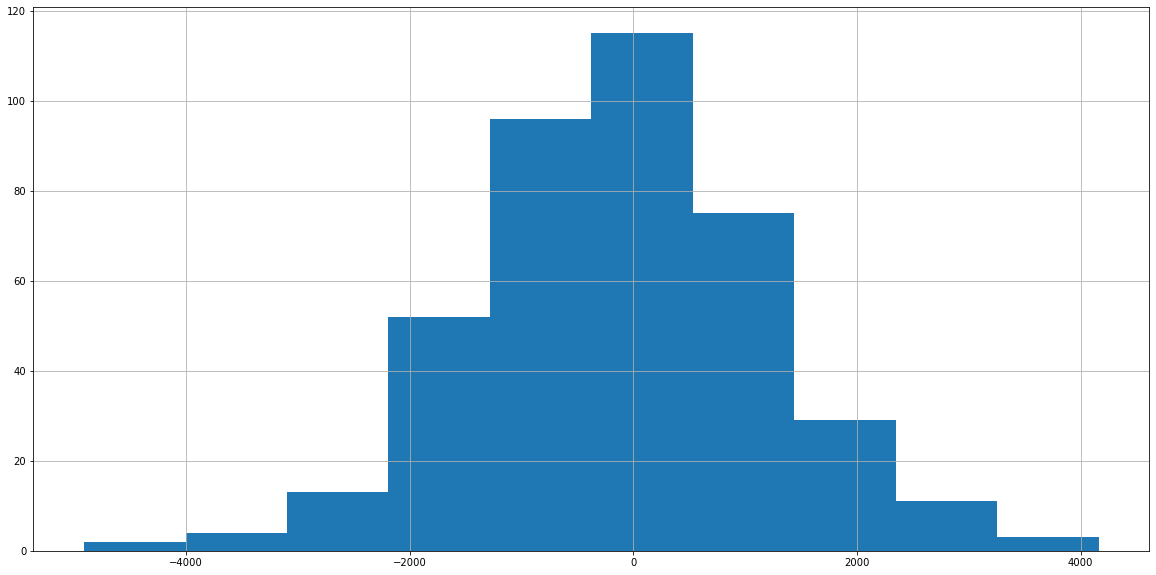

In [80]:
car_results = pd.DataFrame({'Predicted':y_pred, 'Actual':y_test, 'Residual':y_pred - y_test})
car_results.Residual.hist()

### Comparing models
Since we are about to reduce the number of predictors, we need to decide what is the best set of predictors.  One way to compare models of course is just to look at the outcomes and see which is best, but this can be misleading.  Several criteria for evaluating and comparing models are based on metrics computed from training data alone.  One popular method is _adjusted_ $R^2$.  This is defined as 
$$R^2_{adj}=1-\frac{n-1}{n-p-1}(1-R^2)$$ 
where $R^2$ is the proportion of variance explained by by a single predictor, _n_ represents the number of observations and _p_ is the number of predictors.  A higher $R^2$ means more variance from a single predictor.  But if we use an adjusted score because otherwise we would automatically get higher scores simply by adding more predictors.  There are other approaches as well [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) and [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion).  In each case a higher value means a better set of predictors.  Since they all produce the same outcomes, we'll show the values, but not go into the formulas

array([[<AxesSubplot:title={'center':'Predicted'}>,
        <AxesSubplot:title={'center':'Actual'}>],
       [<AxesSubplot:title={'center':'Residual'}>, <AxesSubplot:>]],
      dtype=object)

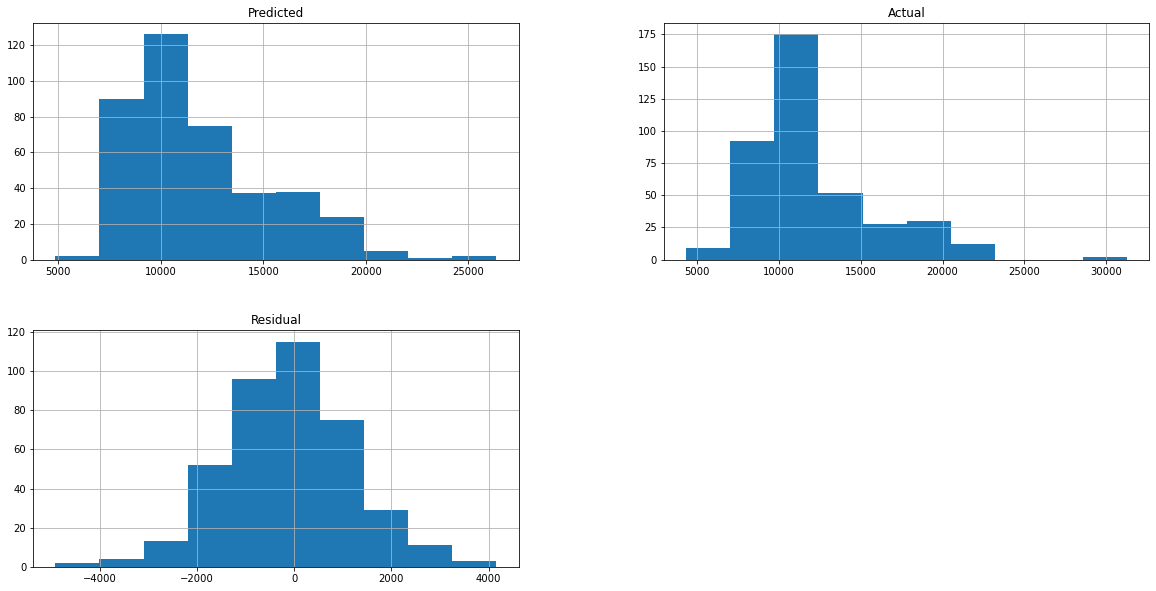

In [79]:
def train_model(factors):
    pass

def score_model(model, factors):
    pass